### Financial Machine Learning

지금까지 배운 내용을 토대로 금융 머신러닝 프로젝트에서 전략 수립과 연구가 어떻게 이뤄지는지 간단한 파이프라인을 그려 보도록 한다

#### 1. Data Import

yahoo finance에서 IBM의 가격 정보를 불러온다

In [2]:
import numpy as np
import pandas as pd

import yfinance as yf

start_date = '1962-01-01'
end_date = '2024-01-14'

ibm = yf.download('IBM', start = start_date, end = end_date)
ibm_ret = np.log(ibm.Close / ibm.Close.shift(1)).dropna()
ibm_ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
1962-01-03    0.008703
1962-01-04   -0.010015
1962-01-05   -0.019890
1962-01-08   -0.018928
1962-01-09    0.011760
Name: Close, dtype: float64

#### 2. Fractionally Differentiated Features

Fractionally Differentiated Feature를 생성하여 ibm에 추가한다

In [3]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
import statsmodels.api as sm

In [3]:
def calculate_difference(df : pd.DataFrame, end = 1, numbers = 11) :
    cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
    out = pd.DataFrame(columns = cols)
    for d in np.linspace(0, end, numbers):
        try:
            df1 = np.log(df).dropna()
            df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d, thres = 1e-5)
            corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
            df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
            out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
        except Exception as e:
            print(f'd: {d}, error: {e}')
            continue
    return out

ibm_d = calculate_difference(ibm[['Close']], numbers = 21)

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,-1.066003,7.284372e-01,1.0,15603.0,-2.861725,1.000000
0.05,-4.157448,7.771261e-04,1.0,5.0,-3.929280,0.997437
0.10,-3.815187,2.755703e-03,1.0,5.0,-3.929280,0.989884
0.15,-6.566583,8.130451e-09,1.0,6.0,-3.646238,0.978864
0.20,-1.978747,2.959687e-01,1.0,9.0,-3.289881,0.951627
0.25,-2.324737,1.641139e-01,1.0,14.0,-3.104184,0.767731
0.30,-3.110540,2.578296e-02,1.0,21.0,-3.013098,0.371443
0.35,-2.594828,9.407096e-02,1.0,33.0,-2.954127,0.617911
0.40,-2.397038,1.425740e-01,1.0,52.0,-2.918973,0.823273
0.45,-2.363082,1.524283e-01,1.0,83.0,-2.897048,0.790618


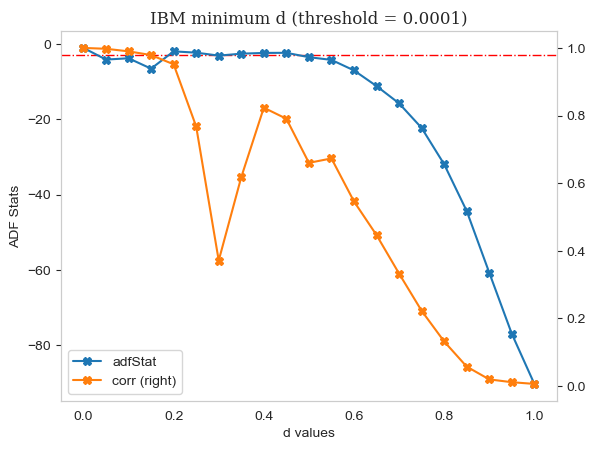

In [4]:
import matplotlib.pyplot as plt

f,ax = plt.subplots()
ax.axhline(ibm_d['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ibm_d[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('IBM minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(ibm_d)

0.35차분이 적절해 보이므로 0.35차분을 수행한다

In [4]:
frac = FractionalDifferentiatedFeatures.fracDiff_FFD(ibm[['Close']], 0.35)
ibm['fracdiff'] = frac

#### 3. Technical Features

ta library를 활용하여 다음과 같이 feature를 만들어 주도록 한다

In [5]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi
from ta.volume import ease_of_movement
from ta.volume import volume_price_trend

ibm['return'] = ibm_ret

indicator_bb = BollingerBands(close = ibm["Close"], window = 20, window_dev = 1)

ibm['bb_bbm'] = indicator_bb.bollinger_mavg()
ibm['bb_bbh'] = indicator_bb.bollinger_hband()
ibm['bb_bbl'] = indicator_bb.bollinger_lband()

ibm['mfi'] = money_flow_index(
    high = ibm.High, low = ibm.Low, 
    close = ibm.Close, volume = ibm.Volume, window = 20
)
ibm['obv'] = on_balance_volume(close = ibm.Close, volume = ibm.Volume)
ibm['rsi'] = rsi(close = ibm.Close, window = 21)
ibm['vwap'] = volume_weighted_average_price(
    high = ibm['High'], low = ibm['Low'],
    close = ibm['Close'], volume = ibm['Volume'], window = 20)
ibm['tsi'] = tsi(close = ibm['Close'], window_fast = 13, window_slow = 15)
ibm['eom'] = ease_of_movement(
    high = ibm['High'], low = ibm.Low, volume = ibm.Volume, window = 20
)
ibm['vpt'] = volume_price_trend(
    close = ibm.Close,
    volume = ibm.Volume
)

#### 4. MicroStructural Features

시장미시구조적 특성을 추가하자

In [6]:
from FinancialMachineLearning.features.microstructure import *
spread = CorwinSchultz(high = ibm.High, low = ibm.Low)
cs_estimator = spread.corwin_schultz_estimator(window = 20)
ibm['corwin_schultz'] = cs_estimator

In [7]:
bp_vol = spread.becker_parkinson_vol(window = 20)
ibm['becker_parkinson'] = bp_vol

#### 5. Primary Modeling

13주차에서 배운 개념을 활용하자

Primary Model에서는 방향만을 추정한다. 여기서는 Bollinger Band전략을 사용하여 가격이 상승할 것인지, 하락할 것인지 labeling을 하자

In [8]:
ibm['label'] = 0
ibm.loc[(ibm['Close'] > ibm['bb_bbh']), 'label'] = 1
ibm.loc[(ibm['Close'] < ibm['bb_bbl']), 'label'] = -1
ibm.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,return,bb_bbm,bb_bbh,...,mfi,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,7.374124,7.374124,7.291268,7.291268,1.555767,407940,NaN,NaN,NaN,NaN,...,NaN,407940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1962-01-03,7.291268,7.355003,7.291268,7.355003,1.569366,305955,NaN,0.008703,NaN,NaN,...,NaN,713895,NaN,NaN,NaN,-0.199161,2674.438080,NaN,NaN,0
1962-01-04,7.355003,7.355003,7.278521,7.281708,1.553726,274575,NaN,-0.010015,NaN,NaN,...,NaN,439320,NaN,NaN,NaN,-0.177529,-61.795600,NaN,NaN,0
1962-01-05,7.272148,7.272148,7.125558,7.138305,1.523129,384405,NaN,-0.019890,NaN,NaN,...,NaN,54915,NaN,NaN,NaN,-4.496378,-7632.089436,NaN,NaN,0
1962-01-08,7.131931,7.131931,6.947100,7.004461,1.494568,572685,NaN,-0.018928,NaN,NaN,...,NaN,-517770,NaN,NaN,NaN,-5.142523,-18370.025715,NaN,NaN,0


#### 6. Meta Labeling

Secondary Model은 Primary Model에서 나온 방향을 이용해 거래의 실행 여부만을 평가한다. 3개의 레이블[-1, 0, 1]을 이진 분류 모형[0, 1]으로 다시 labeling을 진행한다. 이 과정을 Meta Labeling이라고 한다

In [9]:
ibm['meta_label'] = 0
ibm.loc[(ibm['label'] == 1) | (ibm['label'] == -1), 'meta_label'] = 1
ibm.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,return,bb_bbm,bb_bbh,...,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,7.374124,7.374124,7.291268,7.291268,1.555767,407940,NaN,NaN,NaN,NaN,...,407940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1962-01-03,7.291268,7.355003,7.291268,7.355003,1.569366,305955,NaN,0.008703,NaN,NaN,...,713895,NaN,NaN,NaN,-0.199161,2674.438080,NaN,NaN,0,0
1962-01-04,7.355003,7.355003,7.278521,7.281708,1.553726,274575,NaN,-0.010015,NaN,NaN,...,439320,NaN,NaN,NaN,-0.177529,-61.795600,NaN,NaN,0,0
1962-01-05,7.272148,7.272148,7.125558,7.138305,1.523129,384405,NaN,-0.019890,NaN,NaN,...,54915,NaN,NaN,NaN,-4.496378,-7632.089436,NaN,NaN,0,0
1962-01-08,7.131931,7.131931,6.947100,7.004461,1.494568,572685,NaN,-0.018928,NaN,NaN,...,-517770,NaN,NaN,NaN,-5.142523,-18370.025715,NaN,NaN,0,0


#### 7. Secondary Modeling

Meta Label을 target으로 지정하고, 2번에서 지정한 technical feature들을 이용하여 이진 분류 모형을 수행해 보자. 여기서, Bollinger Band 관련 feature들은 labeling에 사용되었으므로 고려하지 않는다

모형의 검증을 위해 test data는 0.2로 지정하고 shuffle = False로 지정한다

In [10]:
matrix = ibm.drop(['Open','High','Low','Close','Volume','Adj Close','bb_bbh','bb_bbl','bb_bbm'], axis = 1)
matrix.dropna(inplace = True)
matrix.head()

,fracdiff,return,mfi,obv,rsi,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,
1969-05-12,1.200569,-0.001530,69.165310,81877742,61.684860,15.355317,37.463763,-3.764557,760888.380791,0.009894,0.001875,0,0
1969-05-13,1.450500,0.015198,69.539480,82193634,65.582100,15.384013,37.672697,7.866144,765725.917407,0.000000,0.009461,1,1
1969-05-14,1.486666,0.007513,72.809496,82616218,67.326871,15.427290,39.019354,8.554148,768912.829582,0.000000,0.022748,1,1
1969-05-15,1.224052,-0.012048,71.783856,82220830,62.042975,15.469598,35.825099,-4.930210,764177.656681,0.002789,0.006607,0,0
1969-05-16,1.282955,0.001514,72.099234,82526262,62.429964,15.501793,33.712731,1.683259,764640.421947,0.016621,0.000000,0,0


In [11]:
from sklearn.model_selection import train_test_split

X = matrix.drop(['meta_label','label'], axis = 1)
y = matrix['meta_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

Random Forest를 사용한다

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 6,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = X_train, y = y_train)
oob_score = fit.oob_score_

#### 8. Feature Importances

각 변수의 설명력을 확인해 본다

In [13]:
cont = pd.Series(X_train.index, index = X_train.index, name = 't1') # 포지션 보유 한도 임의 지정

In [15]:
from FinancialMachineLearning.feature_importance.importance import *
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score
from sklearn.metrics import accuracy_score

cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont)
oos_score = ml_cross_val_score(forest, X_train, y_train, cv_gen = cv_gen, scoring = accuracy_score).mean()
mdi = mean_decrease_impurity(fit, X_train.columns)

In [16]:
mdi = mean_decrease_impurity(fit, X_train.columns)

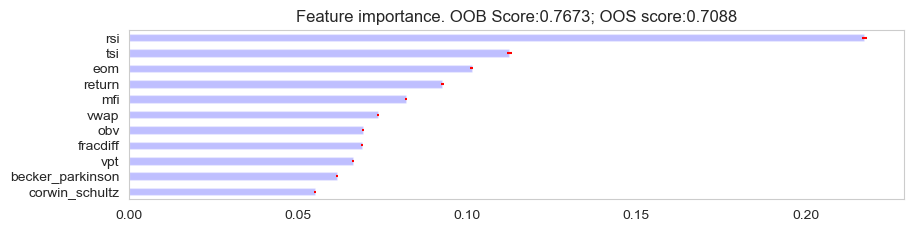

In [17]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './IBM_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [18]:
from sklearn.metrics import log_loss

mda = mean_decrease_accuracy(fit, X_train, y_train, cv_gen, scoring = log_loss)

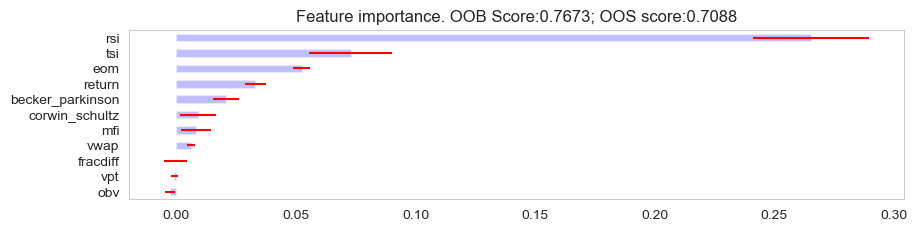

In [19]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './IBM_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

필요한 경우 SHAP Model로도 분석할 수 있지만, 여기서는 시간이 오래 걸리므로 추정하지 않는다

#### 9. 결과 출력

여러 성과 지표들을 통해 Machine Learning Model의 추정 결과를 확인한다

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

y_prob = forest.predict_proba(X_test)[:, 1]
y_pred = forest.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6569978245105149


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.56      1220
           1       0.66      0.78      0.72      1538

    accuracy                           0.66      2758
   macro avg       0.65      0.64      0.64      2758
weighted avg       0.66      0.66      0.65      2758


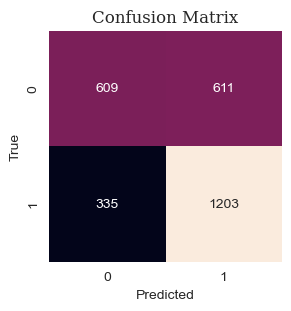

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

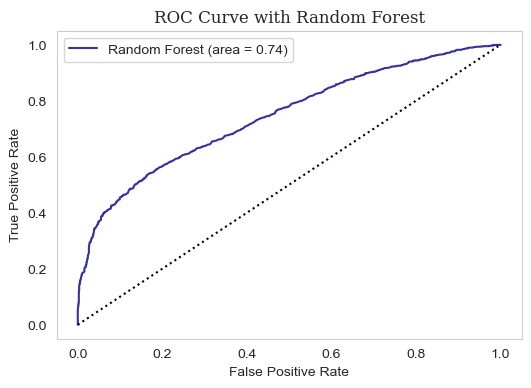

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

#### 10. Betting Size

In [24]:
from FinancialMachineLearning.bet_sizing.bet_sizing import *

In [25]:
event_prob = pd.DataFrame()
event_prob['t1'] = pd.Series(X_test.index, index = X_test.index, name = 't1')
event_prob['prob'] = fit.predict_proba(X_test)[:,1]
event_prob.index = pd.Series(X_test.index, index = X_test.index, name = 't1')

In [26]:
event_prob['side'] = matrix['label']

In [27]:
event_prob

,t1,prob,side
t1,,,
2013-01-30,2013-01-30,0.655,1
2013-01-31,2013-01-31,0.666,1
2013-02-01,2013-02-01,0.879,1
2013-02-04,2013-02-04,0.577,1
2013-02-05,2013-02-05,0.572,0
...,...,...,...
2024-01-08,2024-01-08,0.535,0
2024-01-09,2024-01-09,0.566,-1
2024-01-10,2024-01-10,0.433,0


In [29]:
event_prob['bet_size_prob'] = de_prado_bet_size(prob_series = event_prob['prob'])

In [27]:
# event_prob['bet_size_prob'] = bet_size_probability(events = event_prob, prob = event_prob['prob'], num_classes = 3)

In [30]:
event_prob

,t1,prob,side,bet_size_prob
t1,,,,
2013-01-30,2013-01-30,0.655,1,0.627812
2013-01-31,2013-01-31,0.666,1,0.637567
2013-02-01,2013-02-01,0.879,1,0.877407
2013-02-04,2013-02-04,0.577,1,0.561928
2013-02-05,2013-02-05,0.572,0,0.557849
...,...,...,...,...
2024-01-08,2024-01-08,0.535,0,0.527972
2024-01-09,2024-01-09,0.566,-1,0.552969
2024-01-10,2024-01-10,0.433,0,0.000000


In [31]:
from multiprocessing import cpu_count

avg_active_bet_sizes = avg_active_signals(event_prob.rename(columns = {'bet_size_prob': 'signal'}), num_threads = cpu_count())
event_prob['avg_active_bet_size'] = avg_active_bet_sizes

2024-01-15 00:12:40.663087 100.0% mp_avg_active_signals done after 0.03 minutes. Remaining 0.0 minutes.


In [32]:
display(event_prob)

,t1,prob,side,bet_size_prob,avg_active_bet_size
t1,,,,,
2013-01-30,2013-01-30,0.655,1,0.627812,0
2013-01-31,2013-01-31,0.666,1,0.637567,0
2013-02-01,2013-02-01,0.879,1,0.877407,0
2013-02-04,2013-02-04,0.577,1,0.561928,0
2013-02-05,2013-02-05,0.572,0,0.557849,0
...,...,...,...,...,...
2024-01-08,2024-01-08,0.535,0,0.527972,0
2024-01-09,2024-01-09,0.566,-1,0.552969,0
2024-01-10,2024-01-10,0.433,0,0.000000,0


In [33]:
print("Summary statistics on the bet size columns:")
display(event_prob[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,2758.000000,2758.000000,2758.0
mean,0.597420,0.450990,0.0
std,0.186851,0.346210,0.0
min,0.115000,0.000000,0.0
25%,0.465000,0.000000,0.0
50%,0.567000,0.553781,0.0
75%,0.732000,0.699791,0.0
max,0.998000,1.000000,0.0


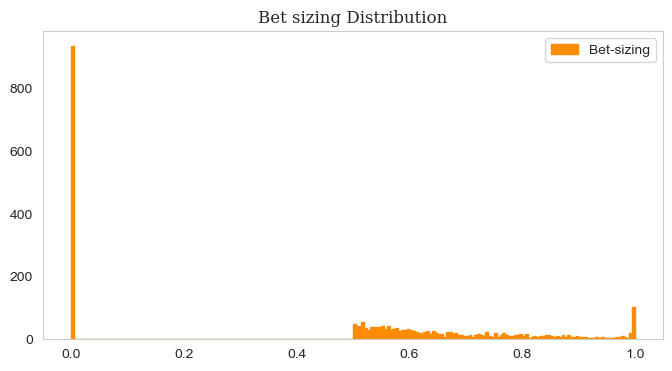

In [34]:
plt.figure(figsize = (8, 4))
plt.hist(
    event_prob.bet_size_prob, 
    bins = 200, 
    color = 'darkorange', 
    edgecolor = 'darkorange', 
    label = 'Bet-sizing'
)
plt.legend()
plt.grid(False)
plt.title('Bet sizing Distribution', fontsize = 12, fontfamily = 'Serif')
plt.show()

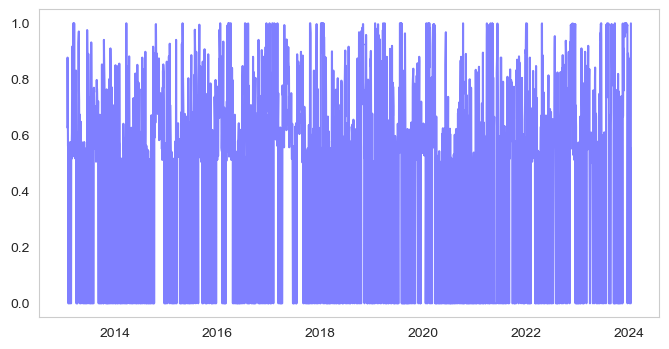

In [35]:
plt.figure(figsize = (8, 4))
plt.plot(event_prob.bet_size_prob, color = 'blue', alpha = 0.5)
plt.grid(False)

Text(0.5, 1.0, 'backtest with betting size')

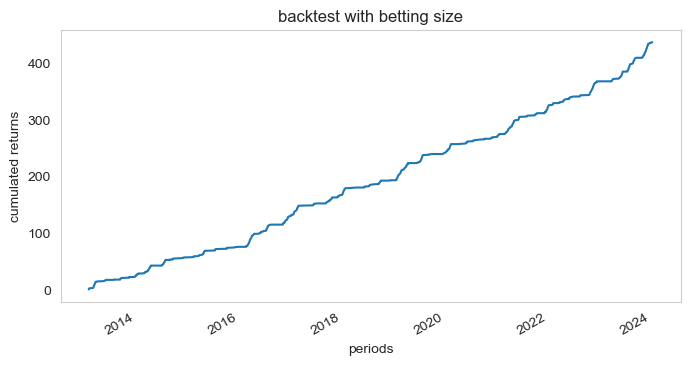

In [45]:
event_prob[event_prob['side'] == 1].bet_size_prob.cumsum().plot(figsize = (8, 4))
plt.grid(False)
plt.xlabel('periods')
plt.ylabel('cumulated returns')
plt.title('backtest with betting size')